In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from keras.layers import Input,Dense
from keras.models import Model

Using TensorFlow backend.


<h3> Sparse Autoencoder </h3>

<h5> Adding a sparsity constraint to encoded respresentations </h5>

In [3]:
from keras import regularizers

encoding_dim = 32
input_img = Input(shape=(784,))

encoded = Dense(encoding_dim,activation='relu',
               activity_regularizer=regularizers.l1(10e-8))(input_img) ## add a Dense layer with a L1 activity regularizer
decoded = Dense(784,activation='sigmoid')(encoded)

autoencoder = Model(input_img,decoded) #creating autoencoder model

<h3> Create encoder model </h3>

In [4]:
encoder = Model(input_img,encoded)

<h3> Create decoder model </h3>

In [5]:
encoded_input = Input(shape=(encoding_dim,)) #placeholder for encoded 32 dim input
decoder_layer = autoencoder.layers[-1] #retreive last layer of autoencoder model , -1 as last layer

decoder = Model(encoded_input,decoder_layer(encoded_input))  #decoder model, also we can use decoder = Model(encoded_input,decoded) 

In [6]:
#compile autoencoder
autoencoder.compile(optimizer='adadelta',loss='binary_crossentropy') #compile

<h3> Prepare input data </h3>

In [7]:
#MNIST dataset

from keras.datasets import mnist
(x_train,_),(x_test,_) = mnist.load_data()

In [8]:
#Normalization between 0,1

x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

x_train = x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


<h3> Train autoencoder </h3>

In [9]:
autoencoder.fit(x_train,x_train,
               epochs = 100,
               batch_size=256,
               shuffle=True,
               validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.3655 - val_loss: 0.2739
Epoch 2/100
60000/60000 [==============================] - 1s 11us/step - loss: 0.2671 - val_loss: 0.2564
Epoch 3/100
60000/60000 [==============================] - 1s 11us/step - loss: 0.2452 - val_loss: 0.2315
Epoch 4/100
60000/60000 [==============================] - 1s 11us/step - loss: 0.2233 - val_loss: 0.2130
Epoch 5/100
60000/60000 [==============================] - 1s 11us/step - loss: 0.2086 - val_loss: 0.2013
Epoch 6/100
60000/60000 [==============================] - 1s 11us/step - loss: 0.1984 - val_loss: 0.1925
Epoch 7/100
60000/60000 [==============================] - 1s 11us/step - loss: 0.1904 - val_loss: 0.1851
Epoch 8/100
60000/60000 [==============================] - 1s 11us/step - loss: 0.1837 - val_loss: 0.1789
Epoch 9/100
60000/60000 [==============================] - 1s 11us/step - loss: 0.1779 - val_loss: 0.1

In [10]:
#encode and decode some digits

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

<h3> Display Results </h3>

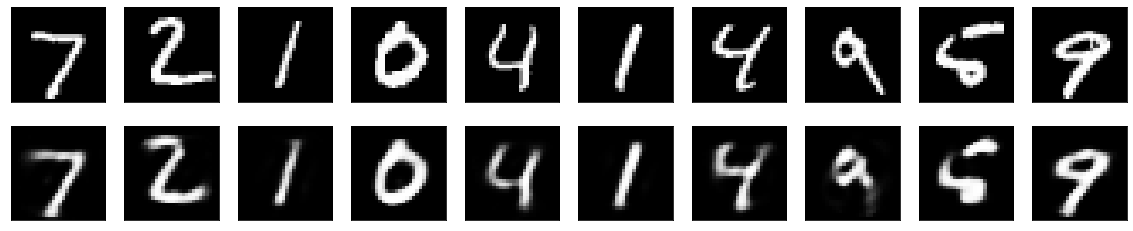

In [11]:

n=10 #how mnay digits we want to display
plt.figure(figsize=(20,4))

for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #to display reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show() # got better results with l1 = 10e-8

<h3> Denoising Autoencoder </h3>

<h4> Prepare Input data </h4>

In [12]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

<h4> Normalizing data and Reshape </h4>

In [13]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

<h4> Adding Noise factor </h4>

In [14]:
noise_factor = 0.5 # 50% noise
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

#clipping - having values between 0,1

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

<h4> Plotting Noisy Data </h4>

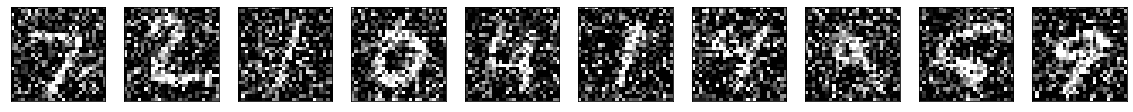

In [16]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<h4> Configure Autoencoder </h4>

In [21]:
input_img = tf.keras.layers.Input(shape=(28,28,1))

# encoded part
x = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(input_img) #kernal = 32, size = 3 x 3 
x = tf.keras.layers.MaxPooling2D((2,2),padding='same')(x) #maxpooling filter of 2 x 2
x = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)

encoded = tf.keras.layers.MaxPool2D((2,2),padding='same')(x) #the representation is (7,7,32)

#decoded part

x = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2,2))(x) #upsamples images increases the dimensions
x = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = tf.keras.layers.UpSampling2D((2,2))(x)

decoded = tf.keras.layers.Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)

autoencoder = tf.keras.models.Model(input_img,decoded)
autoencoder.compile(optimizer='adadelta',loss='binary_crossentropy')

In [26]:
autoencoder.fit(x_train_noisy, x_train,
epochs=20, # for better result take it as 100
batch_size=128,
shuffle=True,
validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 47us/sample - loss: 0.1445 - val_loss: 0.1430
Epoch 2/20
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1442 - val_loss: 0.1427
Epoch 3/20
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1440 - val_loss: 0.1424
Epoch 4/20
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1437 - val_loss: 0.1422
Epoch 5/20
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1434 - val_loss: 0.1419
Epoch 6/20
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1432 - val_loss: 0.1416
Epoch 7/20
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1429 - val_loss: 0.1413
Epoch 8/20
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1426 - val_loss: 0.1411
Epoch 9/20
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1424 - val_

In [27]:
decoded_imgs = autoencoder.predict(x_test)

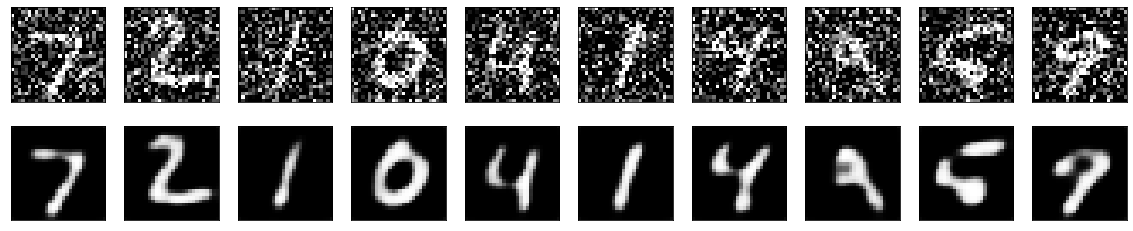

In [28]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #to display reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()